## Code to analyze FS output

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [24]:
qpn_dir = "/home/nikhil/projects/Parkinsons/qpn/"

ukbb_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

session = "ses-01"
FS_dir = f"{qpn_dir}/derivatives/freesurfer/v6.0.1/"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"
FS_DKT_dir = f"{FS_dir}/freesurfer-agg/{session}/"

qpn_DKT_csv = f"{FS_DKT_dir}/DKTatlas_average_thickness.csv"

qpn_subcortical_csv = f"{FS_DKT_dir}/aseg_subcortical_volumes.csv"

tabular_dir = f"{qpn_dir}/tabular/"

current_release = "release_Nov2022"

figs_dir = "../figs/surf/"

# Current mr_proc manifest
current_mr_proc_manifest_csv = f"{tabular_dir}{current_release}/mr_proc_manifest.csv"


In [3]:
### DKT metadata

# DKT fields and labels
ukbb_dkt_fields = f"{ukbb_dir}/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{ukbb_dir}/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{ukbb_dir}/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{ukbb_dir}/region_field_ids/UKBB_ASEG_vol_Fields.csv"

In [4]:
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]

DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

lh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["Field ID"].values.astype("str"))
rh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["Field ID"].values.astype("str"))
rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])

# hemi specific dict
lh_DKT_field_roi_dict = dict(zip(lh_DKT_fields,rois))
rh_DKT_field_roi_dict = dict(zip(rh_DKT_fields,rois))

DKT_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_roi
0,62,27174,Mean_thickness of caudalanteriorcingulate (lef...,Mean_thickness,caudalanteriorcingulate,lh,lh_caudalanteriorcingulate
1,63,27267,Mean_thickness of caudalanteriorcingulate (rig...,Mean_thickness,caudalanteriorcingulate,rh,rh_caudalanteriorcingulate
2,64,27175,Mean_thickness of caudalmiddlefrontal (left he...,Mean_thickness,caudalmiddlefrontal,lh,lh_caudalmiddlefrontal
3,65,27268,Mean_thickness of caudalmiddlefrontal (right h...,Mean_thickness,caudalmiddlefrontal,rh,rh_caudalmiddlefrontal
4,66,27176,Mean_thickness of cuneus (left hemisphere),Mean_thickness,cuneus,lh,lh_cuneus


In [5]:
CT_DKT_df = pd.read_csv(qpn_DKT_csv)
CT_DKT_df = CT_DKT_df.drop(columns=["Unnamed: 0"])
CT_DKT_df = CT_DKT_df.rename(columns={"subject_id":"bids_id"})

qpn_bids_ids = list(CT_DKT_df["bids_id"])
print(f"n_bids: {len(qpn_bids_ids)}")
CT_DKT_df.head()

n_bids: 163


,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27288,27289,27290,27291,27292,27293,27294,27295,27296,27297
0,sub-PD00668D788170,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.350,2.049,...,2.445,2.416,2.357,2.135,2.402,2.285,2.604,2.372,2.272,2.835
1,sub-MNI0056D864854,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.148,2.106,...,2.246,2.401,2.372,2.167,2.415,2.434,2.644,2.386,2.092,2.617
2,sub-PD01677D994657,2.741,2.577,1.888,2.819,2.552,2.468,2.683,2.173,2.225,...,2.539,2.436,2.794,2.336,2.575,2.247,2.895,2.770,2.654,3.138
3,sub-MNI0147D193242,2.736,2.149,2.011,3.295,2.705,2.265,2.955,2.229,2.230,...,2.358,2.213,2.769,2.129,2.357,1.929,2.594,2.236,2.129,2.675
4,sub-PD00032D891772,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.257,2.125,...,2.533,2.319,2.816,2.294,2.487,2.203,2.784,2.480,2.380,2.736


In [6]:
qpn_demographics_df = pd.read_csv(current_mr_proc_manifest_csv)

qpn_demographics_df = qpn_demographics_df[qpn_demographics_df["bids_id"].isin(qpn_bids_ids)]

print(f"n_demographics_subs: {len(qpn_demographics_df)}")
qpn_demographics_df.head()

n_demographics_subs: 161


,participant_id,sex,dob,group,visit_01,visit_02,bids_id
0,MNI0056,M,1942-05-21,PD,2021-08-18,NaN,sub-MNI0056D864854
1,MNI0058,M,1964-03-14,PD,2021-08-18,NaN,sub-MNI0058D197308
2,MNI0068,M,1952-08-05,PD,2021-08-27,NaN,sub-MNI0068D842090
3,MNI0079,F,1971-11-25,PD,2021-12-22,NaN,sub-MNI0079D760662
4,MNI0103,M,1939-08-17,PD,2021-08-11,NaN,sub-MNI0103D369057


In [7]:
qpn_demographics_df.groupby(["group","sex"]).count()

participant_id  dob  visit_01  visit_02  bids_id
group sex                                                  
CTRL  F                21   20        21         0       21
      M                10   10        10         1       10
PD    F                45   45        45         3       45
      M                84   84        84         9       84

In [8]:
demo_cols = ["bids_id","sex","dob","group"]
CT_DKT_df = pd.merge(CT_DKT_df,qpn_demographics_df[demo_cols],on="bids_id",how="left")
CT_DKT_df.head()

,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27291,27292,27293,27294,27295,27296,27297,sex,dob,group
0,sub-PD00668D788170,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.350,2.049,...,2.135,2.402,2.285,2.604,2.372,2.272,2.835,M,1941-12-14,PD
1,sub-MNI0056D864854,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.148,2.106,...,2.167,2.415,2.434,2.644,2.386,2.092,2.617,M,1942-05-21,PD
2,sub-PD01677D994657,2.741,2.577,1.888,2.819,2.552,2.468,2.683,2.173,2.225,...,2.336,2.575,2.247,2.895,2.770,2.654,3.138,F,1964-12-01,PD
3,sub-MNI0147D193242,2.736,2.149,2.011,3.295,2.705,2.265,2.955,2.229,2.230,...,2.129,2.357,1.929,2.594,2.236,2.129,2.675,M,1945-06-15,CTRL
4,sub-PD00032D891772,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.257,2.125,...,2.294,2.487,2.203,2.784,2.480,2.380,2.736,M,1950-10-25,PD


In [9]:
lh_CT_DKT_df = CT_DKT_df[lh_DKT_fields + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[rh_DKT_fields + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_field_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_field_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)


CT_DKT_df

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiorfrontal,superiorparietal,superiortemporal,supramarginal,transversetemporal,bids_id,sex,dob,group,hemi
0,2.419,2.414,2.009,2.761,2.560,2.338,2.483,2.767,2.350,2.049,...,2.427,2.270,2.568,2.344,2.131,sub-PD00668D788170,M,1941-12-14,PD,lh
1,2.209,2.546,1.945,2.934,2.509,2.347,2.480,2.609,2.148,2.106,...,2.503,2.478,2.518,2.283,2.200,sub-MNI0056D864854,M,1942-05-21,PD,lh
2,2.741,2.577,1.888,2.819,2.552,2.468,2.683,3.007,2.173,2.225,...,2.644,2.271,2.744,2.537,2.441,sub-PD01677D994657,F,1964-12-01,PD,lh
3,2.736,2.149,2.011,3.295,2.705,2.265,2.955,3.026,2.229,2.230,...,2.388,1.919,2.567,2.155,2.483,sub-MNI0147D193242,M,1945-06-15,CTRL,lh
4,2.690,2.512,2.034,3.973,2.580,2.315,2.730,2.880,2.257,2.125,...,2.557,2.175,2.711,2.475,2.546,sub-PD00032D891772,M,1950-10-25,PD,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2.145,2.522,2.030,3.899,2.724,2.538,2.727,2.875,2.047,2.422,...,2.494,2.371,2.802,2.494,2.638,sub-PD00869D303763,F,1959-05-10,PD,rh
159,2.155,2.386,1.808,3.232,2.528,2.348,2.677,2.613,2.065,2.124,...,2.399,2.278,2.660,2.378,2.364,sub-PD01320D775438,F,1956-11-18,CTRL,rh
160,2.514,2.480,2.182,3.152,2.842,2.483,2.736,2.969,2.560,2.357,...,2.540,2.324,2.849,2.605,2.497,sub-MNI0200D646765,M,1950-11-04,CTRL,rh
161,2.404,2.425,1.806,3.653,2.687,2.359,2.687,3.010,2.498,2.243,...,2.398,2.153,2.739,2.479,2.505,sub-PD00122D725903,M,1968-11-23,PD,rh


## Colormaps
- https://proplot.readthedocs.io/en/latest/colormaps.html

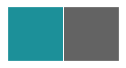

In [22]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)


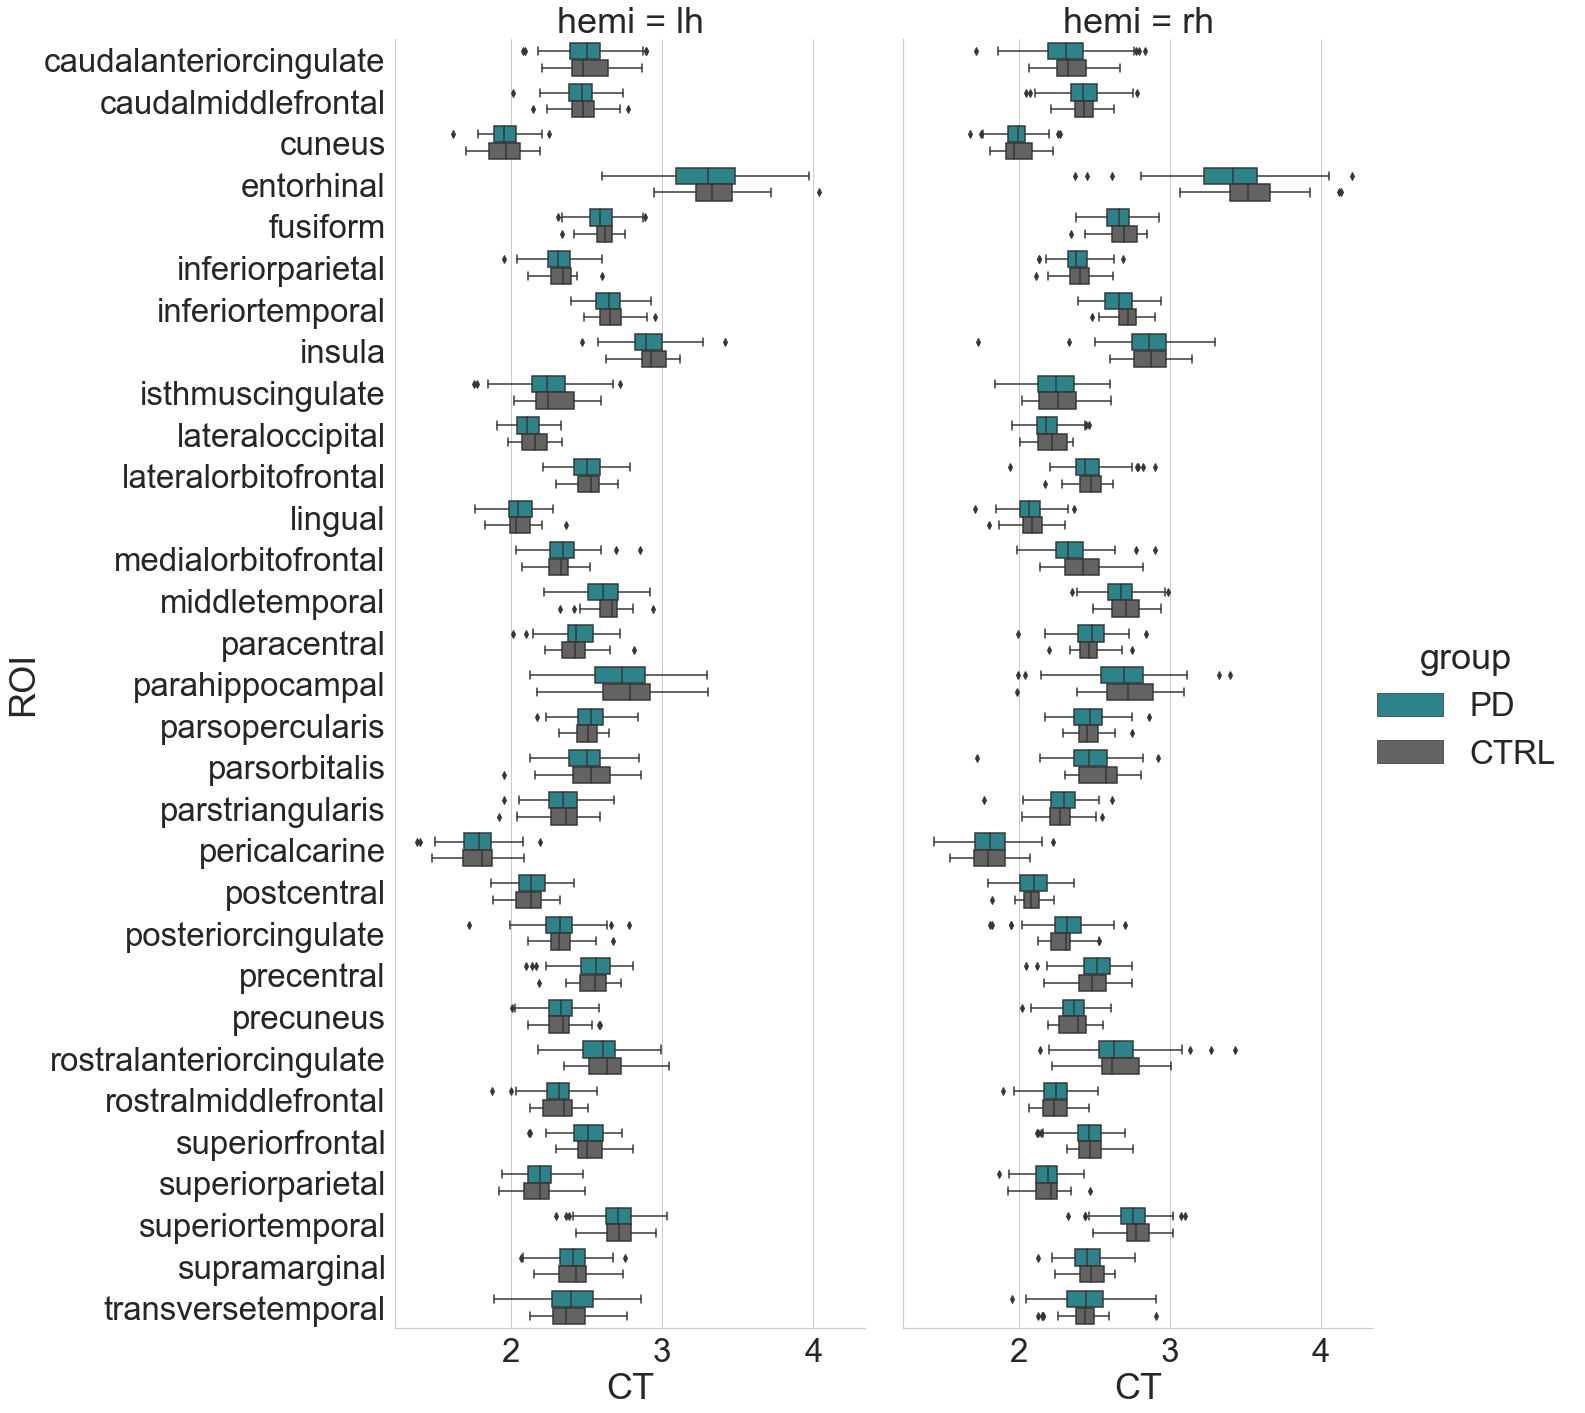

In [23]:
CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT",
)

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)


sns.set(font_scale=3)
with sns.axes_style("whitegrid"):

    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

### Volumetric measures

In [105]:
global_ASEG_field_roi_dict

{'26523': '3rd-Ventricle',
 '26524': '4th-Ventricle',
 '26525': '5th-Ventricle',
 '26526': 'Brain-Stem',
 '26514': 'BrainSeg',
 '26515': 'BrainSegNotVent',
 '26516': 'BrainSegNotVentSurf',
 '26535': 'CC-Anterior',
 '26533': 'CC-Central',
 '26534': 'CC-Mid-Anterior',
 '26532': 'CC-Mid-Posterior',
 '26531': 'CC-Posterior',
 '26527': 'CSF',
 '26521': 'EstimatedTotalIntraCranial',
 '26530': 'Optic-Chiasm',
 '26517': 'SubCortGray',
 '26519': 'SupraTentorial',
 '26520': 'SupraTentorialNotVent',
 '26518': 'TotalGray',
 '26522': 'VentricleChoroid',
 '26528': 'WM-hypointensities',
 '26529': 'non-WM-hypointensities'}

In [91]:
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

ASEG_fields_sorted = list(ASEG_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

lh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["Field ID"].values.astype("str"))
rh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Right-"]["Field ID"].values.astype("str"))
global_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["Field ID"].values.astype("str"))
hemi_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["roi"])
global_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["roi"])

# hemi specific dict
lh_ASEG_field_roi_dict = dict(zip(lh_ASEG_fields,hemi_rois))
rh_ASEG_field_roi_dict = dict(zip(rh_ASEG_fields,hemi_rois))
global_ASEG_field_roi_dict = dict(zip(global_ASEG_fields,global_rois))
ASEG_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_ROI
0,43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle
1,44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle
2,45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle
3,46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area
4,47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area


In [92]:
vol_ASEG_df = pd.read_csv(qpn_subcortical_csv)
vol_ASEG_df = vol_ASEG_df.drop(columns=["Unnamed: 0"])
vol_ASEG_df = vol_ASEG_df.rename(columns={"subject_id":"bids_id"})

qpn_bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(qpn_bids_ids)}")

# UKB has more fields than freesurfer enlists
lh_ASEG_fields = list(set(lh_ASEG_fields) & set(vol_ASEG_df.columns))
rh_ASEG_fields = list(set(rh_ASEG_fields) & set(vol_ASEG_df.columns))
global_ASEG_fields = list(set(global_ASEG_fields) & set(vol_ASEG_df.columns))

vol_ASEG_df.head()


n_bids: 163


,bids_id,26523,26524,26525,26564,26595,26563,26594,26526,26527,...,26558,26589,26565,26596,26528,26567,26598,26529,26566,26597
0,sub-PD00668D788170,2885.600098,1519.500000,0.0,380.600006,435.799988,1173.800049,1349.000000,22150.000000,1584.199951,...,7281.100098,7183.600098,4244.200195,4110.700195,4413.700195,841.200012,853.599976,0.000000,19.299999,79.500000
1,sub-MNI0056D864854,2971.100098,2498.600098,0.0,381.299988,388.799988,1364.099976,1682.099976,20670.599609,1837.900024,...,6604.500000,6633.899902,3832.800049,3528.100098,6660.799805,930.000000,1064.699951,0.000000,20.000000,63.700001
2,sub-PD01677D994657,903.200012,1242.500000,0.0,400.899994,541.099976,1275.900024,1401.500000,21717.900391,811.000000,...,6945.299805,7031.600098,3584.199951,3677.300049,1031.300049,290.600006,368.000000,0.000000,29.100000,14.000000
3,sub-MNI0147D193242,1718.599976,1588.199951,0.0,468.600006,429.799988,1521.800049,1512.699951,20151.300781,1761.900024,...,6637.500000,5760.899902,3704.699951,3290.399902,6444.000000,841.799988,1131.800049,48.700001,90.900002,21.700001
4,sub-PD00032D891772,1853.900024,2748.300049,0.0,588.200012,626.700012,1553.800049,1511.099976,22589.099609,1486.000000,...,6905.200195,6690.799805,4125.299805,4099.100098,1096.900024,865.299988,764.500000,0.000000,107.599998,19.700001


In [93]:
demo_cols = ["bids_id","sex","dob","group"]
vol_ASEG_df = pd.merge(vol_ASEG_df,qpn_demographics_df[demo_cols],on="bids_id",how="left")
vol_ASEG_df.head()

,bids_id,26523,26524,26525,26564,26595,26563,26594,26526,26527,...,26596,26528,26567,26598,26529,26566,26597,sex,dob,group
0,sub-PD00668D788170,2885.600098,1519.500000,0.0,380.600006,435.799988,1173.800049,1349.000000,22150.000000,1584.199951,...,4110.700195,4413.700195,841.200012,853.599976,0.000000,19.299999,79.500000,M,1941-12-14,PD
1,sub-MNI0056D864854,2971.100098,2498.600098,0.0,381.299988,388.799988,1364.099976,1682.099976,20670.599609,1837.900024,...,3528.100098,6660.799805,930.000000,1064.699951,0.000000,20.000000,63.700001,M,1942-05-21,PD
2,sub-PD01677D994657,903.200012,1242.500000,0.0,400.899994,541.099976,1275.900024,1401.500000,21717.900391,811.000000,...,3677.300049,1031.300049,290.600006,368.000000,0.000000,29.100000,14.000000,F,1964-12-01,PD
3,sub-MNI0147D193242,1718.599976,1588.199951,0.0,468.600006,429.799988,1521.800049,1512.699951,20151.300781,1761.900024,...,3290.399902,6444.000000,841.799988,1131.800049,48.700001,90.900002,21.700001,M,1945-06-15,CTRL
4,sub-PD00032D891772,1853.900024,2748.300049,0.0,588.200012,626.700012,1553.800049,1511.099976,22589.099609,1486.000000,...,4099.100098,1096.900024,865.299988,764.500000,0.000000,107.599998,19.700001,M,1950-10-25,PD


In [94]:
lh_vol_ASEG_df = vol_ASEG_df[lh_ASEG_fields + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[rh_ASEG_fields + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_ASEG_fields + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_ASEG_field_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_ASEG_field_roi_dict)
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_field_roi_dict)

vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)


vol_ASEG_df

,Putamen,Hippocampus,Amygdala,Caudate,choroid-plexus,Cerebellum-White-Matter,Cerebellum-Cortex,Lateral-Ventricle,Thalamus-Proper,VentralDC,vessel,Accumbens-area,Inf-Lat-Vent,Pallidum,bids_id,sex,dob,group,hemi
0,4601.399902,3667.899902,1173.800049,3048.800049,841.200012,14220.799805,50515.601562,12196.299805,7281.100098,4244.200195,19.299999,380.600006,566.299988,1984.000000,sub-PD00668D788170,M,1941-12-14,PD,lh
1,4640.000000,3633.199951,1364.099976,3506.000000,930.000000,13299.500000,49035.000000,30950.300781,6604.500000,3832.800049,20.000000,381.299988,1578.400024,1685.800049,sub-MNI0056D864854,M,1942-05-21,PD,lh
2,4496.399902,3112.899902,1275.900024,2716.600098,290.600006,14780.099609,48556.000000,5203.799805,6945.299805,3584.199951,29.100000,400.899994,698.700012,1727.099976,sub-PD01677D994657,F,1964-12-01,PD,lh
3,4531.399902,3689.600098,1521.800049,3327.899902,841.799988,13551.700195,50057.199219,11070.700195,6637.500000,3704.699951,90.900002,468.600006,614.799988,1741.900024,sub-MNI0147D193242,M,1945-06-15,CTRL,lh
4,4820.299805,3872.199951,1553.800049,2741.300049,865.299988,12986.599609,49177.101562,17603.199219,6905.200195,4125.299805,107.599998,588.200012,707.099976,2033.300049,sub-PD00032D891772,M,1950-10-25,PD,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,4490.000000,4182.299805,1952.400024,3796.899902,369.899994,13416.799805,49561.199219,16673.099609,7485.899902,3918.500000,57.000000,546.099976,196.300003,1963.800049,sub-PD00869D303763,F,1959-05-10,PD,rh
159,4684.399902,4781.700195,1897.500000,3525.100098,818.599976,16473.199219,52115.601562,11506.599609,6978.899902,4215.799805,36.099998,460.299988,699.599976,2191.399902,sub-PD01320D775438,F,1956-11-18,CTRL,rh
160,5062.200195,4327.500000,1884.800049,4193.100098,1206.900024,14461.900391,63487.000000,18584.099609,8291.599609,4541.200195,48.900002,525.099976,411.100006,1742.400024,sub-MNI0200D646765,M,1950-11-04,CTRL,rh
161,4961.600098,4464.700195,1757.000000,3596.500000,694.400024,14884.900391,58300.000000,11048.200195,6968.200195,4244.500000,22.500000,688.900024,600.799988,2004.900024,sub-PD00122D725903,M,1968-11-23,PD,rh


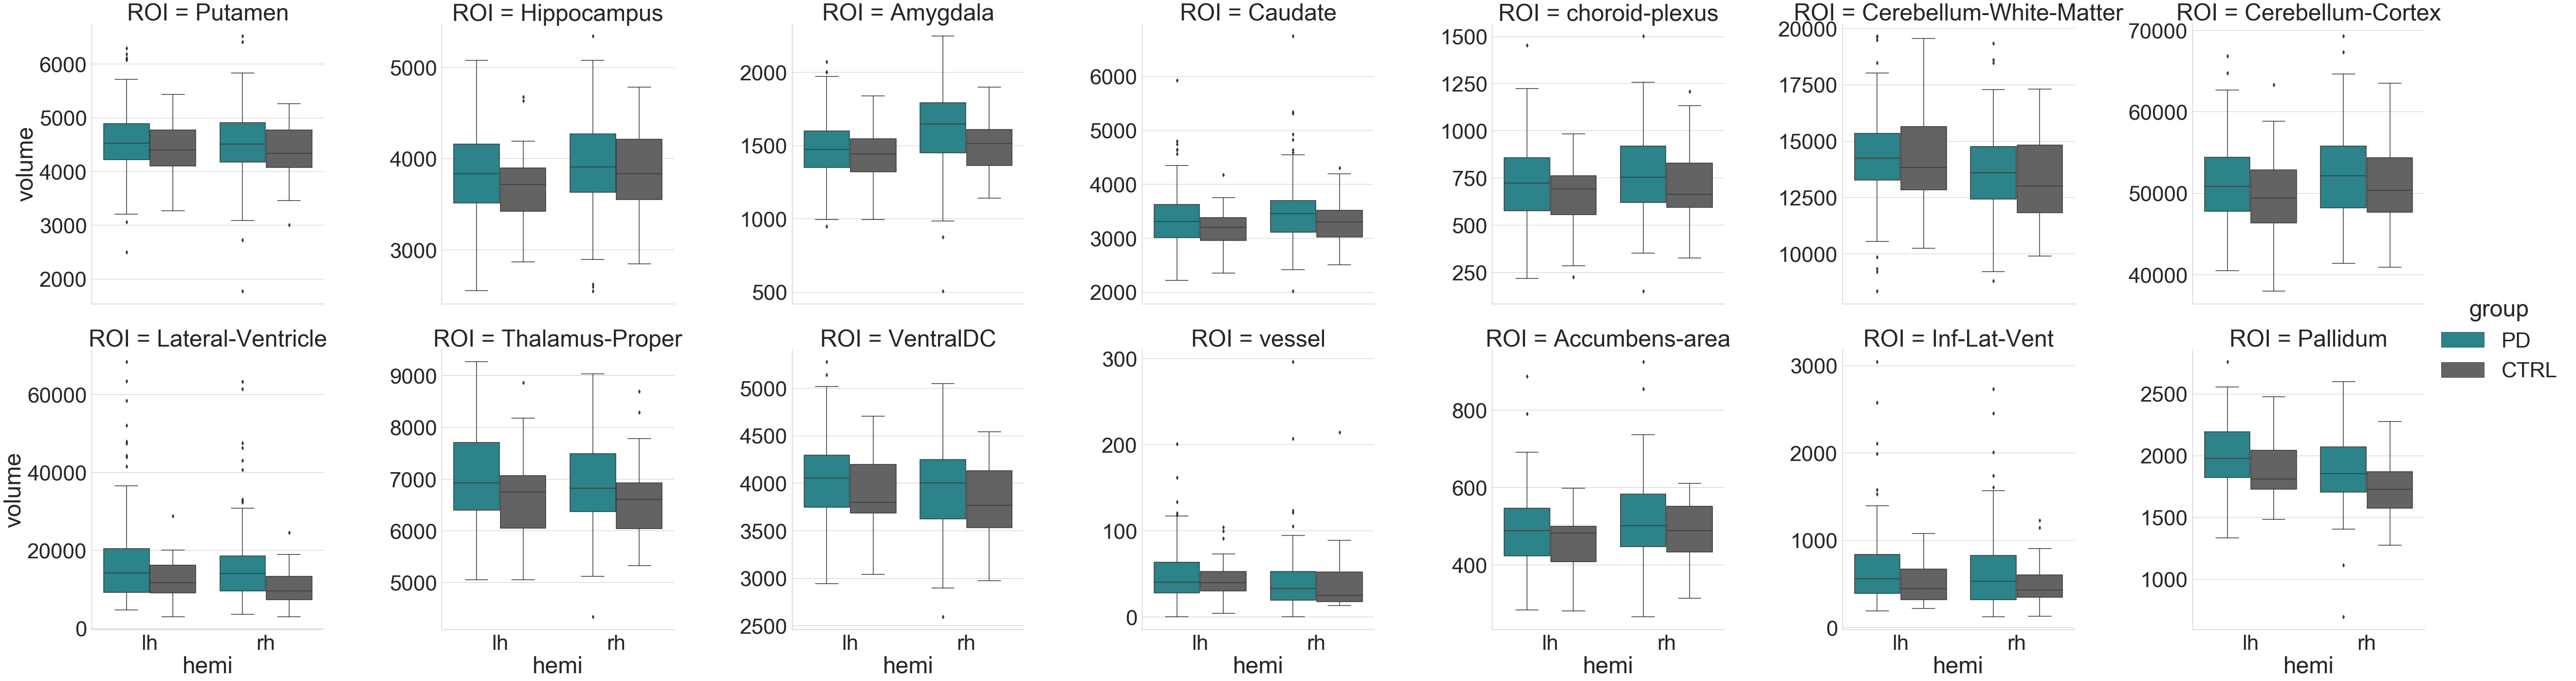

In [95]:
vol_ASEG_df_melt = vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)


sns.set(font_scale=4)
with sns.axes_style("whitegrid"):

    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=7,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

In [103]:
global_vol_ASEG_df

,WM-hypointensities,CSF,Optic-Chiasm,5th-Ventricle,non-WM-hypointensities,4th-Ventricle,Brain-Stem,3rd-Ventricle,bids_id,sex,dob,group,hemi
0,4413.700195,1584.199951,131.500000,0.0,0.000000,1519.500000,22150.000000,2885.600098,sub-PD00668D788170,M,1941-12-14,PD,global
1,6660.799805,1837.900024,141.399994,0.0,0.000000,2498.600098,20670.599609,2971.100098,sub-MNI0056D864854,M,1942-05-21,PD,global
2,1031.300049,811.000000,156.500000,0.0,0.000000,1242.500000,21717.900391,903.200012,sub-PD01677D994657,F,1964-12-01,PD,global
3,6444.000000,1761.900024,194.000000,0.0,48.700001,1588.199951,20151.300781,1718.599976,sub-MNI0147D193242,M,1945-06-15,CTRL,global
4,1096.900024,1486.000000,181.199997,0.0,0.000000,2748.300049,22589.099609,1853.900024,sub-PD00032D891772,M,1950-10-25,PD,global
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,3695.899902,1353.500000,168.899994,0.0,0.000000,1044.000000,21614.900391,947.200012,sub-PD00869D303763,F,1959-05-10,PD,global
159,1169.199951,908.200012,150.100006,0.0,0.000000,2276.000000,23826.099609,1192.300049,sub-PD01320D775438,F,1956-11-18,CTRL,global
160,3088.000000,1365.699951,106.500000,0.0,0.000000,1757.000000,26360.400391,1575.099976,sub-MNI0200D646765,M,1950-11-04,CTRL,global
161,1100.199951,1184.800049,153.000000,0.0,0.000000,1735.199951,20517.199219,1340.599976,sub-PD00122D725903,M,1968-11-23,PD,global


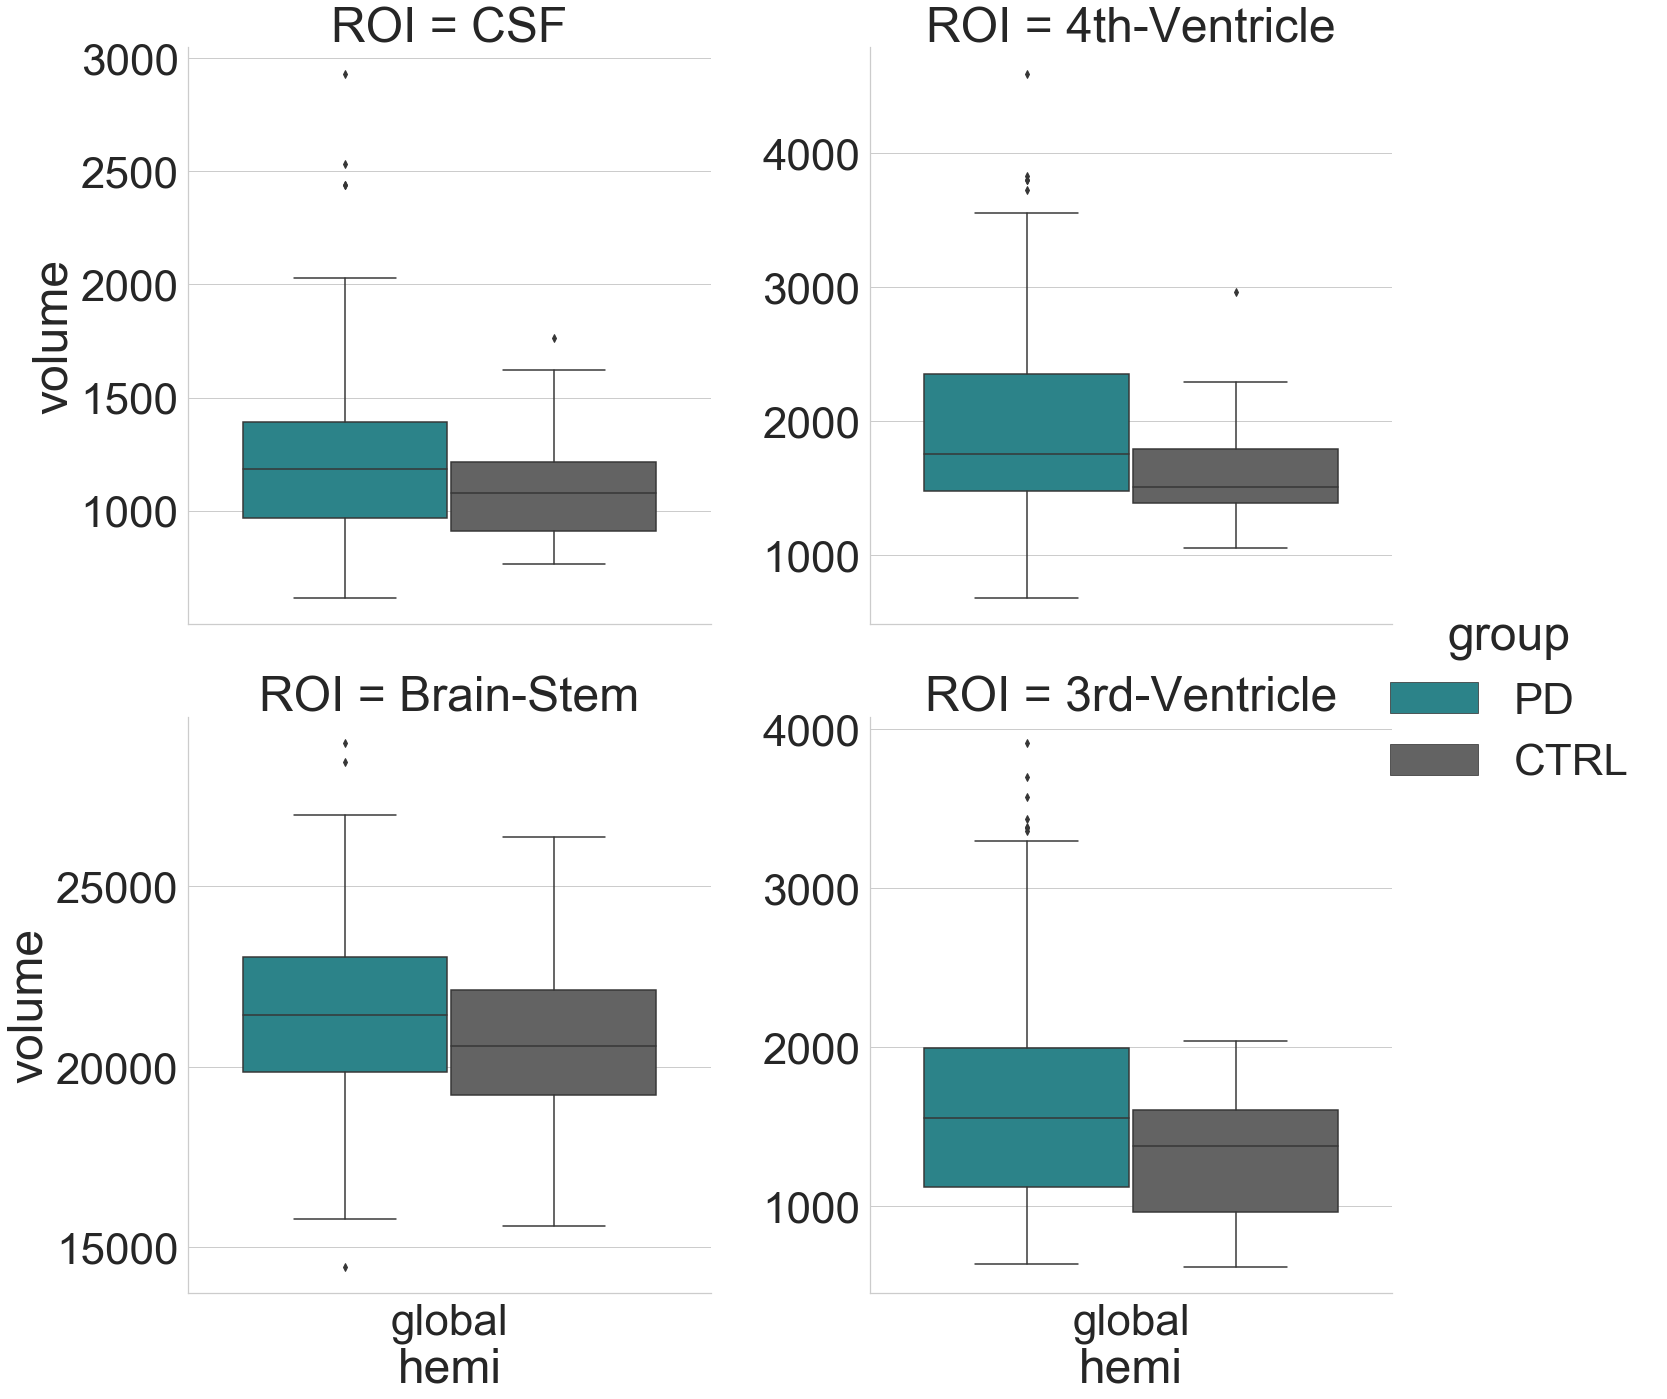

In [112]:
global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=2,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

### Surface maps

In [5]:
from matplotlib.colors import ListedColormap
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
cmap = "Spectral" #"cubehelix"
view = 'lateral'
sns.set(font_scale=2)

In [7]:
fwhm_list = [5] #[0,5,10]
DX_groups = ["CTRL","PD"] 
hemi_list = ["lh", "rh"]

for fwhm in fwhm_list:
    for i, group in enumerate(DX_groups):
        for j, hemi in enumerate(hemi_list):
            CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{group}_{fwhm}mm.mgh")
            avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))

            stat_map = avg_CT

            if hemi == "lh":
                hemisphere = "left"
            else:
                hemisphere = "right"

            bg_map=fsaverage[f"sulc_{hemisphere}"]
            fs_surf = fsaverage[f'pial_{hemisphere}']
            
            fig = plt.figure(figsize=(10, 6))
            fig_file = f"{figs_dir}/{hemi}_surf_CT_{group}_{fwhm}mm.png"
            
            with sns.axes_style("white"):
                plotting.plot_surf_stat_map(
                    fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
                    colorbar=True, threshold=1, vmax=4.3, output_file=fig_file, cmap=cmap, figure=fig
            )

#bg_map=bg_map,vmax=4.5,

### CTRL - PD

In [30]:
fwhm = 5
cmap = "Spectral"
hemi_list = ["lh", "rh"]

for j, hemi in enumerate(hemi_list):
    CT_img_CTRL = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_CTRL_{fwhm}mm.mgh")
    avg_CT_CTRL = np.squeeze(np.mean(CT_img_CTRL.get_fdata(),axis=3))

    CT_img_PD = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_PD_{fwhm}mm.mgh")
    avg_CT_PD = np.squeeze(np.mean(CT_img_PD.get_fdata(),axis=3))

    stat_map = avg_CT_CTRL - avg_CT_PD

    if hemi == "lh":
        hemisphere = "left"
    else:
        hemisphere = "right"

    bg_map=fsaverage[f"sulc_{hemisphere}"]
    fs_surf = fsaverage[f'pial_{hemisphere}']
    
    fig = plt.figure(figsize=(10, 6))
    fig_file = f"{figs_dir}/{hemi}_surf_CT_diff_{fwhm}mm.png"
    
    with sns.axes_style("white"):
        plotting.plot_surf_stat_map(
            fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
            colorbar=True, threshold=0.15, output_file=fig_file, cmap=cmap, figure=fig
        )

In [136]:
def parse_aseg(aseg_file, stat_measure):
    """Function to parse aseg.stats file from freesurfer"""

    aseg_data = np.loadtxt(aseg_file, dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")

    aseg_df = pd.DataFrame(data=aseg_data)
    aseg_df = aseg_df[["f4","f3"]].rename(columns={"f3":stat_measure, "f4":"hemi_ROI"})
    aseg_df["hemi_ROI"] = aseg_df["hemi_ROI"].str.decode('utf-8') 

    # print(f"number of ROIs in aseg file: {len(aseg_df)}")

    # Get global volumes from the "measure" lines
    file_data = open(aseg_file, 'r')
    lines = file_data.readlines()
    measure_lines = []
    for line in lines:
        if "Measure" in line:
            measure_lines.append(line)
    global_df = pd.DataFrame(measure_lines)
    global_df = global_df.replace('\n','', regex=True)
    global_df = global_df[0].str.split(",", expand=True)[[1,3]]
    global_df = global_df.rename(columns = {1:"hemi_ROI",3:stat_measure})

    aseg_df = pd.concat([aseg_df,global_df],axis=0)

    return aseg_df


In [137]:
aseg_file = f"{FS_dir}/output/ses-01/sub-MNI0056D864854/stats/aseg.stats"
stat_measure = "Volume_mm3"

df = parse_aseg(aseg_file, stat_measure)

df

,hemi_ROI,Volume_mm3
0,Left-Lateral-Ventricle,30950.3
1,Left-Inf-Lat-Vent,1578.4
2,Left-Cerebellum-White-Matter,13299.5
3,Left-Cerebellum-Cortex,49035
4,Left-Thalamus-Proper,6604.5
5,Left-Caudate,3506
6,Left-Putamen,4640
7,Left-Pallidum,1685.8
8,3rd-Ventricle,2971.1
9,4th-Ventricle,2498.6
